<a href="https://colab.research.google.com/github/prithwis/parashar21/blob/main/P21_45_11_AshtakVarga_Gochar_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ॐ श्री गणेशाय नमः

![alt text](http://1.bp.blogspot.com/_5QlanosqxiQ/SXLOLTu7S7I/AAAAAAAAAm8/0r6C7lCxsic/S1600-R/p21-header-003.png) <br>


---



[Prithwis Mukerjee](http://www.yantrajaal.com) ||
Website - [Parashar21](https://parashar21.blogspot.com)<br>

Copyright (c) 2022, Prithwis Mukerjee All rights reserved.

This source code is licensed under the GNU GPL v3.0 -style license found in the LICENSE file in the root directory of this source tree.

#Single Chart | Ashtakvarga | Gochar | Time Series

##Rationale

The core 'engine' of Parashar21 is designed to cast multiple horoscopes using the [Python](https://pypi.org/project/pyswisseph/) version of the [Swiss Ephemeris](https://www.astro.com/swisseph/) software, convert the charts to JSON format and then store the charts in a MongoDB database. This is demonstrated in the notebook [P21_45_10_MultiChart_Analysis](https://github.com/prithwis/parashar21/blob/main/P21_45_10_MultiChart_Analysis.ipynb). <br><br>
In this notebook, the focus is an analysis of a single chart, either the Rashi chart or the Navamsa chart along with additional information on Aspects, Conjuncts, Lords, Bhavs, Ashtakvarga points, Dasha and Gochar analysis. <br> <br>
While processing a single chart does not need any kind of database engine we found it economical to skip another ground up development and retain the same code base. Moreover, the Mongo query language has been used to filter out horoscopes that meet certain criteria (as in Yogs or patterns). This search and filter operation would have been difficult without the MongoDB query language. Hence the database is retained. <br> <br>
For full information about this project, please see the [Parashar21](https://prithwis.github.io/parashar21/) github page.


In [1]:
from datetime import datetime
import pytz
print("\033[1m"+'ॐ श्री गणेशाय नमः'+"\033[0m")
print(datetime.now(pytz.timezone('Asia/Calcutta')))

ॐ श्री गणेशाय नमः
2023-08-14 07:23:59.400185+05:30


#SetUp Environment

##Install Software

In [2]:
!python --version
!lsb_release -a
!pip -qq install pyswisseph                                 # https://stackoverflow.com/questions/64277506/pip-install-options-unclear
!pip -qq install python-docx                                # https://python-docx.readthedocs.io/en/latest/
#!/usr/bin/python3 -m pip install "pymongo[srv]"            # Required only if used with Atlas remote servers
!pip -qq install pymongo                                    # Required for Mongo client
#!apt install mongodb > /dev/null                            # install local MongoDB server      --- this part does not work anymore

Python 3.10.12
No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 22.04.2 LTS
Release:	22.04
Codename:	jammy
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 21.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 603.6/603.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.4/300.4 kB 8.6 MB/s eta 0:00:00


In [3]:
#Utility functions
from pymongo import MongoClient
import pandas as pd
import dateutil
import json
from docx import Document
from docx.shared import Inches
from docx.enum.text import WD_ALIGN_PARAGRAPH
from datetime import datetime
from datetime import timedelta
import pytz
from google.colab import files

#import matplotlib.pyplot as plt
#import math

### Install local MongoDB
https://www.mongodb.com/docs/manual/tutorial/install-mongodb-on-ubuntu/ <br>
https://unix.stackexchange.com/questions/715119/system-v-init-service-cant-recongnise-mongod

In [4]:
!curl -fsSL https://pgp.mongodb.com/server-6.0.asc | \
   sudo gpg -o /usr/share/keyrings/mongodb-server-6.0.gpg \
   --dearmor
# --------------------
# NOTE we are using Ubuntu 22.04 hence 'jammy'

!echo "deb [ arch=amd64,arm64 signed-by=/usr/share/keyrings/mongodb-server-6.0.gpg ] https://repo.mongodb.org/apt/ubuntu jammy/mongodb-org/6.0 multiverse" | sudo tee /etc/apt/sources.list.d/mongodb-org-6.0.list
# --------------------
!sudo apt-get update > /dev/null
# --------------------
!sudo apt-get install -y mongodb-org > /dev/null          # error, warning messages may be ignored
# --------------------
!sudo mkdir -p /var/log/mongodb /var/lib/mongodb
# --------------------
!sudo chown `whoami` /var/lib/mongodb /var/log/mongodb/
# -------------------------------------------
#!service mongodb start                                      # start Local MongoDB server instance --- does not work anymore
!nohup mongod --config /etc/mongod.conf &                    # patch for manual start
#!mongod --version
# Connect to local MongoDB
mongoURI = "mongodb://localhost:27017/"                               # for local server
client = MongoClient(mongoURI)
db = client.parashar21
client.list_database_names() # ['admin', 'config', 'local']

deb [ arch=amd64,arm64 signed-by=/usr/share/keyrings/mongodb-server-6.0.gpg ] https://repo.mongodb.org/apt/ubuntu jammy/mongodb-org/6.0 multiverse
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 9.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
nohup: appending output to 'nohup.out'


['admin', 'config', 'local']

### Install, import local modules

In [5]:
#Load p21 modules from github
!wget -O p21.py -q https://raw.githubusercontent.com/prithwis/parashar21/main/utils/p21.py                  # all global variables
!wget -O p21utils.py -q https://raw.githubusercontent.com/prithwis/parashar21/main/utils/p21utils.py        # large number of utility functions
!wget -O p21utilsR.py -q https://raw.githubusercontent.com/prithwis/parashar21/main/utils/p21utilsR.py      # report writing utility functions
!wget -O p21swe.py -q https://raw.githubusercontent.com/prithwis/parashar21/main/utils/p21swe.py            # Swiss Ephemeris functions
!wget -O p21YogInfo.py -q https://raw.githubusercontent.com/prithwis/parashar21/main/utils/p21YogInfo.py    # yog data - description and conditions
# ---------------------------

#!wget -O Saraswati.png -q https://github.com/prithwis/parashar21/raw/main/images/Saraswati02.png
#!wget -O p21logo.png -q https://github.com/prithwis/parashar21/raw/main/images/p21logo-002-1.png



In [6]:
import p21
import p21utils
import p21utilsR
import p21swe
import p21YogInfo
# ------------------------------------------------
# required for multiple imports of the same module
# ------------------------------------------------
import importlib
importlib.reload(p21)
importlib.reload(p21utils)
importlib.reload(p21utilsR)
importlib.reload(p21swe)
importlib.reload(p21YogInfo)

10 Yogs on record
0 : Amala Yog | 10th from Moon OR Lagna should have a benefic
1 : RajLakshana Yog | Jupiter, Venus, Mercury, Moon should be in Lagna or they should be in a Kendra
2 : Chatussagara Yog | All the Kendras 1/4/7/10 are occupied by planets, Ra, Ke not counted here
3 : Adhi678 Yog | Benefics located in 6/7/8th  from Moon
4 : Chandra Mangal Yog | Mars Conjoins Moon or  Mars and Moon in Mutual Aspect
5 : Kemadruma Yog : No planets on either sides of the Moon
6 : Anapha Yog |Planets other than Sun in 12th Place from Moon
7 : Sunapha Yog |Planets other than Sun in 2nd Place from Moon
8 : Dhurdhura Yog | Planets on both sides of the Moon
9 : Gajakesari Yog | Jupiter is in Kendra or 1,4,7,10th from Moon
10 Yogs on record
0 : Amala Yog | 10th from Moon OR Lagna should have a benefic
1 : RajLakshana Yog | Jupiter, Venus, Mercury, Moon should be in Lagna or they should be in a Kendra
2 : Chatussagara Yog | All the Kendras 1/4/7/10 are occupied by planets, Ra, Ke not counted here
3 :

<module 'p21YogInfo' from '/content/p21YogInfo.py'>

In [7]:
# Guess what is happening here :-)
#
!wc *.py | grep total |awk '{print $1 " lines";}'
!sed '/^#/d' *.py | wc |awk '{print $1 " non-comment lines";}'

2624 lines
2380 non-comment lines


### Configure Swiss Ephemeris

In [8]:
#Download Swiss Ephemeris Files
!wget -q http://www.astro.com/ftp/swisseph/ephe/seas_18.se1
!wget -q http://www.astro.com/ftp/swisseph/ephe/semo_18.se1
!wget -q http://www.astro.com/ftp/swisseph/ephe/sepl_18.se1
!mkdir ephe
!mv *.se1 ephe
#------------------------------
# Configure SWE with appropriate parameters
#
p21swe.C01_configSWE()

#Local Functions

## Chart Generation

In [41]:
def genReport(ChartStyle):

    chartData = chart.iloc[0]
    RepID = chart.iloc[0]['pid']['name']+'_'+p21.AnalysisType[0:3]+'_'+ChartStyle[0:1]
    now = datetime.now(pytz.timezone('Asia/Kolkata'))
    fileName = 'p21_'+RepID+'_'+now.strftime("%H%M%S")+'.doc'

    # ---------------------------------------------------------
    p21utilsR.R01_CreateReportDoc(None,None,'SingleChart')        # Creates MS Word Doc called p21.document for Single or MULTIPLE charts
    #p21utilsR.R01A_CreateReportDoc(RepID)                        # Creates MS Word Doc called p21.document for SINGLE chart, deprecated
    # ----------------------------------------------------------

    p21utilsR.R511_parseChartData(chartData)                # Break up database data into useful pieces
                                                            # Creates two primary dicts, GLon, GRet
    p21utilsR.R30_LocateYogs()

    # This is a rather clever hack. During the chart generation, the order in which charts are generated leaves
    # the graha longitudes in the order of the last chart generate
    # Hence there Ashtakvarga points in the output report will carry the points calculated on the basis of the last chart generate
    # and not on the type of analysis that is actually required
    #
    if p21.AnalysisType == 'Rashi' :
        listOfChartTypes = ['Navamsa','Rashi']
    elif p21.AnalysisType == 'Navamsa':
        listOfChartTypes = ['Rashi','Navamsa']
    else:
        print('Error, Unknown Analysis Type')


    for ctype in listOfChartTypes:
        p21.ChartType = ctype
        p21utils.R11_LocateGrahaInRashi()   # Converts Graha Long to Rashi positions
                                            # Rashi Num as well as Rashi name
        if ChartStyle == 'Bengal':
            p21utilsR.R12B_drawChart_Bengal()    # Draw Chart in Bengal style
        if ChartStyle == 'South':
            p21utilsR.R12B_drawChart_South()    # Draw Chart in South style
        if ChartStyle == 'North':
            p21utilsR.R12B_drawChart_North()    # Draw Chart in North style


    p21utilsR.R512_FormatPage('SingleChart')                    # this is where the basic details of the chart are printed out
    p21utilsR.R512_FormatPage2A()                                # this is where the Vimsottari Dasha details for SINGLE chart scenario
    p21utilsR.R512_FormatPage2B()                                # this is where the AshtakVarga details for SINGLE chart scenario
    # ------------------------------------
    if p21.pName == p21.gName:
        RollForward(24,7)
        p21utilsR.R512_FormatPage3_RollForward()
    # ------------------------------------
    p21.document.save(fileName)
    return fileName

print("Executed at ", datetime.now(pytz.timezone('Asia/Kolkata')))

Executed at  2023-08-14 07:58:57.758868+05:30


## Store and Retrieve Function

In [10]:
def StoreRetrieveChart():
    with open('peopleData.json') as json_file:
        oneChart = json.load(json_file)

    db.drop_collection('khona21')
    db.create_collection('khona21')               # Optional collection creation
    p21.kollection = db.khona21                   # Set the collection to work with

    # Insert the single chart
    insert_result = p21.kollection.insert_one(oneChart)
    return(pd.DataFrame(list(p21.kollection.find({},p21.selCols))))

print("Executed at ", datetime.now(pytz.timezone('Asia/Kolkata')))

Executed at  2023-08-14 07:25:10.043396+05:30


# Natal Chart
Data for others can be added by adding an extra line in the cell below. Please follow the same pattern as in the other lines


## Representative Natal Chart Data

In [11]:
# Sample Data for some people
#
#%%writefile peopleData.csv
#Gender,DoB_Day,DoB_Mon,DoB_Year,DoB_Time,TZ_OffHours,PoB_Lat,PoB_Lon,TZ_Name,TZ_Type,Name,tag1,tag2,tag3,tag4,tag5,tag6
#M,17,9,1950,23:11,5.5,23.72,63.36,IST,standard,NDModi,Politician,nil,Administrator,nil,nil,nil
#F,10,10,1954,11:00,5.5,13.08,80.27,IST,standard,Rekha,Actor,nil,Dancer,nil,nil,nil
#M,15,10,1931,1:15,5.5,9.29,79.31,IST,standard,APJAbdulKalam,Engineer,nil,PublicFigure,nil,nil,nil
#F,19,11,1917,23:11,5.5,25.43,81.85,IST,standard,IndiraG,Politician,nil,PublicFigure,nil,nil,nil
#M,15,10,1961,23:42,5.5,22.57,88.37,IST,standard,Person1,dummy,nil,dummy,nil,dummy,nil
#F,19,12,1965,10:26,5.5,22.57,88.37,IST,standard,Person1,dummy,nil,dummy,nil,dummy,nil
#M,9,10,1990,23:09,5.5,22.57,88.37,IST,standard,Person1,dummy,nil,dummy,nil,dummy,nil
#F,12,9,1990,0:52,5.5,22.87,88.37,IST,standard,Person1,dummy,nil,dummy,nil,dummy,nil

#Read Birth Data from a file
#!wget -O peopleData.csv -q https://raw.githubusercontent.com/prithwis/parashar21/main/data/Test5Data.txt # 5 Person Test Data
#!cat peopleData.csv

In [12]:
#Optional  ----------------------------------------------
# Get Lat Long for Place of Birth, in case that is not known
# https://stackoverflow.com/questions/69854674/python-generate-lat-long-points-from-address
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent='your_app_name')
addresses = [
            'Vadnagar, Gujarat, India',
            'Kolkata, West Bengal, India',
            'Prantik, Bolpur, Birbhum, West Bengal, India',
            'Purulia, Purulia, West Bengal,India'
]

coordinates = []
for address in addresses:
    location = geolocator.geocode(address)
    lat, lon = location.latitude, location.longitude
    coordinates.append((lat, lon))

print(coordinates)

[(23.7848358, 72.6346407), (22.5726459, 88.3638953), (23.6970143, 87.6863117), (23.3291882, 86.3672378)]


## Natal Data Preparation

In [33]:
%%writefile peopleData.csv
Gender,DoB_Day,DoB_Mon,DoB_Year,DoB_Time,TZ_OffHours,PoB_Lat,PoB_Lon,TZ_Name,TZ_Type,Name,tag1,tag2,tag3,tag4,tag5,tag6
M,15,10,1961,23:42,5.5,22.57,88.37,IST,standard,Person1,dummy,nil,dummy,nil,dummy,nil

Overwriting peopleData.csv


## Natal Data Analysis
type of analsis Rashi / Navamsa to be specified here

In [34]:
#%%time
df = pd.read_csv('peopleData.csv')
p21.AnalysisType = 'Rashi'                                     # one of ['Rashi','Navamsa']
#p21.AnalysisType = 'Navamsa'                                    # one of ['Rashi','Navamsa']
p21.ChartType = p21.AnalysisType
# ------------------------------------------------------------
# Converts date/time info into a detailed horoscope chart
# Stores the same in a JSON file, to be inserted into a local MongoDB database
#
p21swe.C61_Cast2JSON(df)
#p21utils.SarvaAshtakVarga()                            # Uncomment for debugging Ashtakvarga point calculation
p21.SubMoonLong = p21.GLon['Mo']                        # Preserving Moon Longitude for Gochar
p21utils.GetDasha()                                     # Generates Vimsottari Dasha / Antardasha Details

1 records processed, so far
1  records generated and stored in file peopleData.json


In [35]:
!rm *.doc
!rm *.png

## Natal Chart Generation

In [36]:
%%capture

#p21.printDasha = True
chart = StoreRetrieveChart()
ReportFile = genReport('Bengal')

# Note : The MS-Word file that is generated is available in the Colab VM Drive
# and needs to be downloaded to local laptop / machine for viewing in MS-Word

#ReportFile = genChart('South')


#Gochar Chart

## Gochar Data Preparation

In [37]:
# This cell to be executed ONLY after natal chart has been created, otherwise errors
#
!sed -n 1p peopleData.csv > peopleData2.csv                                  # Copy the Header data
print(p21.gName, p21.SubMoonLong)
now = datetime.now(pytz.timezone('Asia/Kolkata'))
timeTxt = now.strftime("%-d,%-m,%Y,%-H:%-M")

#
# for Gochar chart for any other time, other than now()
#timeTxt = '31,5,2023,9:16'                # any other time in dd,mm,yyyy,hh:mm format will do
#

GocharTxt = 'x,'+timeTxt+',5.5,25.43,81.85,IST,standard,'+p21.gName+',nil,nil,nil,nil,nil,nil'    # Using Lat, Long of Calcutta for Gochar
print(GocharTxt)
with open("peopleData2.csv", 'a') as file1:                                                       # Append Gochar Data
    file1.write(GocharTxt)


_Gochar 250.52
x,14,8,2023,7:57,5.5,25.43,81.85,IST,standard,_Gochar,nil,nil,nil,nil,nil,nil


## Gochar Data Analysis

In [38]:
# Load CSV data into Pandas dataframe
#
df = pd.read_csv('peopleData2.csv')
p21.AnalysisType = 'Rashi'                                     # one of ['Rashi','Navamsa']
#p21.AnalysisType = 'Navamsa'                                    # one of ['Rashi','Navamsa']

p21.ChartType = p21.AnalysisType
p21swe.C61_Cast2JSON(df)                                      # For Gochar, the La Long is set to Natal Moon Long
#print(p21.GLon['La'],p21.GLon['Mo'])
#p21utils.SarvaAshtakVarga()                                     # Uncomment for debugging Ashtakvarga point calculation

La long reset to  250.52 Natal moon position for Gochar
1 records processed, so far
1  records generated and stored in file peopleData.json


In [39]:
def RollForward(numberOfPeriods,periodDuration,allTransits = False,buildMovie = False):
    sDate = datetime.now(pytz.timezone('Asia/Kolkata'))
    cDate = sDate

    s8v = p21utils.SarvaAshtakVarga()
    print(cDate.date())
    RashiSumData =  [[cDate.strftime("%Y-%m-%d")] + s8v[1]]

    RashiCols = ['Date']+ p21.RashiName[1:]

    BhavSumData =  [[cDate.strftime("%Y-%m-%d")] + s8v[3]]
    BhavCols = ['Date']+ p21.BhavList[1:]
    df_RashiSum = pd.DataFrame(data=RashiSumData, columns = RashiCols)
    df_BhavSum = pd.DataFrame(data=BhavSumData, columns = BhavCols)

    p21utils.setData(p21utils.getData(cDate))

    for count in range(numberOfPeriods):
        #print(cDate.date())
        prevGrashiA = p21.GRashiA
        prevGLonRet = p21.GLonRet
        cDate += timedelta(days=periodDuration)
        p21utils.setData(p21utils.getData(cDate))
        s8v = p21utils.SarvaAshtakVarga()

        df_RashiSum.loc[len(df_RashiSum)] = [cDate.strftime("%Y-%m-%d")] + s8v[1]
        df_BhavSum.loc[len(df_BhavSum)] = [cDate.strftime("%Y-%m-%d")] + s8v[3]


    # Convert date column to pandas date format
    df_BhavSum['Date'] = pd.to_datetime(df_BhavSum['Date']).dt.date

    # Set the date column as the index of the dataframe
    df_BhavSum.set_index('Date',inplace=True)
    #return(df_RashiSum, df_BhavSum)
    for i in p21.BhavList[1:]:
        L = [i]                                 # Generating each image for each bhav, one by one
        titleTxt = L[0] + 'Bhav AshtakVarga for '+ p21.GRashiA['La']+' Rashi'
        t = df_BhavSum.plot(y=L,kind='bar', ylim=(15, 45), figsize = (5,5), title = titleTxt, legend=False, fontsize = 5).get_figure();
        iName = 'Bhav'+L[0]+'.png'
        t.savefig(iName)

## Gochar Chart Generation

In [42]:
%%capture

#p21.printDasha = True
chart = StoreRetrieveChart()
ReportFile = genReport('Bengal')

# Note : The MS-Word file that is generated is available in the Colab VM Drive
# and needs to be downloaded to local laptop / machine for viewing in MS-Word


#Time Series

In [20]:
#x,rashiSum,y,bhavSum,z = p21utils.SarvaAshtakVarga()
s8v = p21utils.SarvaAshtakVarga()
print(p21.GRashiN)
rashiSum = s8v[1]
print(rashiSum)
print(p21.GRashiA)
bhavSum = s8v[3]
print(bhavSum)

SarvaAshtakVarga | Rashi {'La': 9, 'Su': 4, 'Mo': 4, 'Ma': 5, 'Me': 5, 'Ju': 1, 'Ve': 4, 'Sa': 11, 'Ra': 1, 'Ke': 7}
 + [27, 43, 26, 19, 24, 31, 29, 23, 34, 25, 30, 26]  =  337
SarvaAshtakVarga | Bhav [' ', 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8]
 + [34, 25, 30, 26, 27, 43, 26, 19, 24, 31, 29, 23]  =  337
Bandhu:  85 Sevak:  99 Poshak:  85 Ghatak:  68
{'La': 9, 'Su': 4, 'Mo': 4, 'Ma': 5, 'Me': 5, 'Ju': 1, 'Ve': 4, 'Sa': 11, 'Ra': 1, 'Ke': 7}
[27, 43, 26, 19, 24, 31, 29, 23, 34, 25, 30, 26]
{'La': 'Dhanu', 'Su': 'Karkat', 'Mo': 'Karkat', 'Ma': 'Simha', 'Me': 'Simha', 'Ju': 'Mesh', 'Ve': 'Karkat', 'Sa': 'Kumbh', 'Ra': 'Mesh', 'Ke': 'Tula'}
[34, 25, 30, 26, 27, 43, 26, 19, 24, 31, 29, 23]


SarvaAshtakVarga | Rashi {'La': 9, 'Su': 4, 'Mo': 4, 'Ma': 5, 'Me': 5, 'Ju': 1, 'Ve': 4, 'Sa': 11, 'Ra': 1, 'Ke': 7}
 + [27, 43, 26, 19, 24, 31, 29, 23, 34, 25, 30, 26]  =  337
SarvaAshtakVarga | Bhav [' ', 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8]
 + [34, 25, 30, 26, 27, 43, 26, 19, 24, 31, 29, 23]  =  337
Bandhu:  85 Sevak:  99 Poshak:  85 Ghatak:  68
2023-08-14
La long reset to  250.52 Natal moon position for Gochar
La long reset to  250.52 Natal moon position for Gochar
SarvaAshtakVarga | Rashi {'La': 9, 'Su': 5, 'Mo': 6, 'Ma': 6, 'Me': 5, 'Ju': 1, 'Ve': 4, 'Sa': 11, 'Ra': 1, 'Ke': 7}
 + [25, 34, 32, 28, 20, 27, 32, 26, 31, 24, 31, 27]  =  337
SarvaAshtakVarga | Bhav [' ', 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8]
 + [31, 24, 31, 27, 25, 34, 32, 28, 20, 27, 32, 26]  =  337
Bandhu:  76 Sevak:  85 Poshak:  95 Ghatak:  81
La long reset to  250.52 Natal moon position for Gochar
SarvaAshtakVarga | Rashi {'La': 9, 'Su': 5, 'Mo': 10, 'Ma': 6, 'Me': 5, 'Ju': 1, 'Ve': 4, 'Sa': 11, 'Ra': 1, 'Ke': 

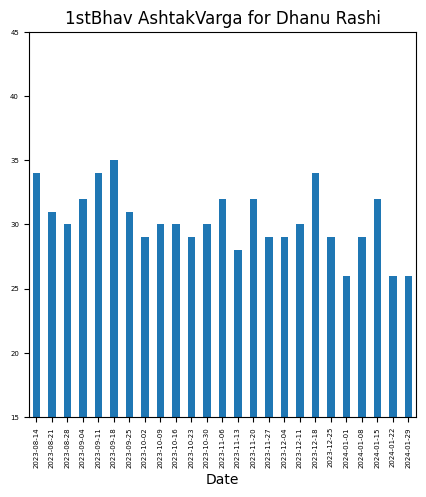

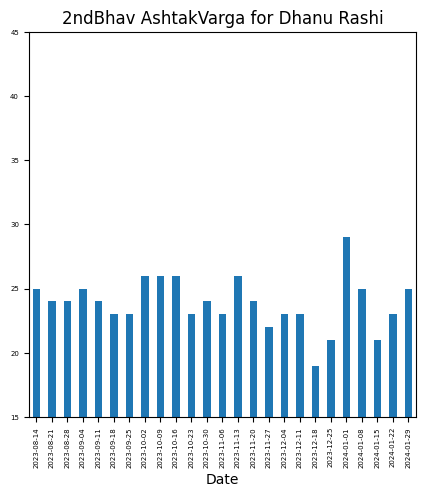

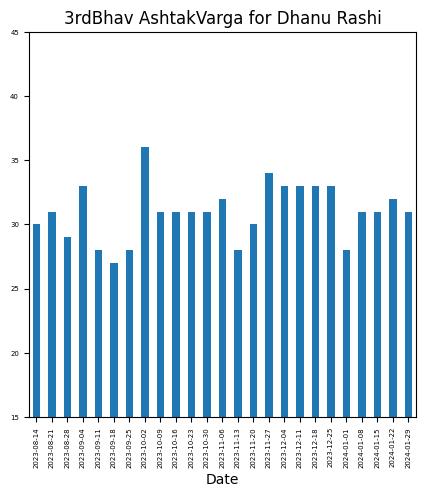

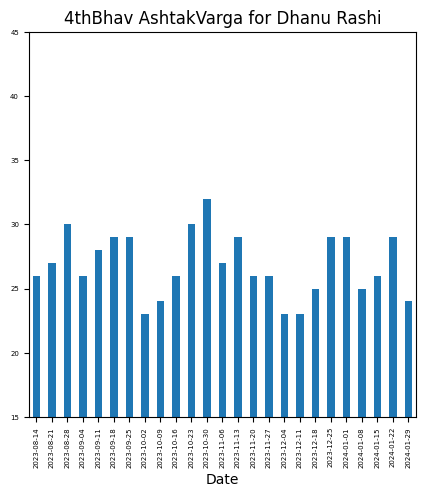

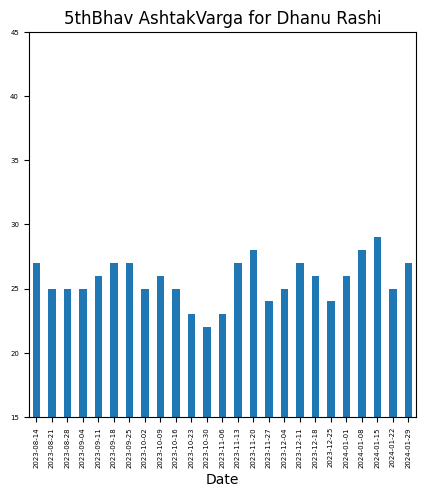

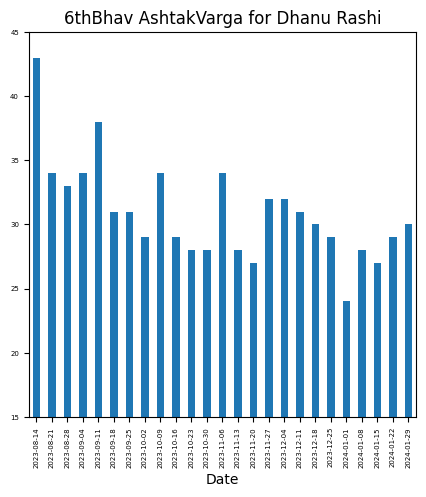

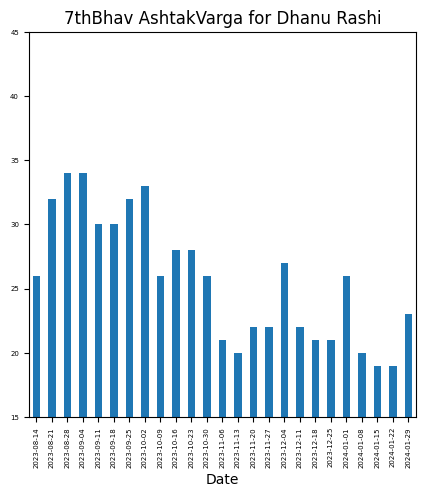

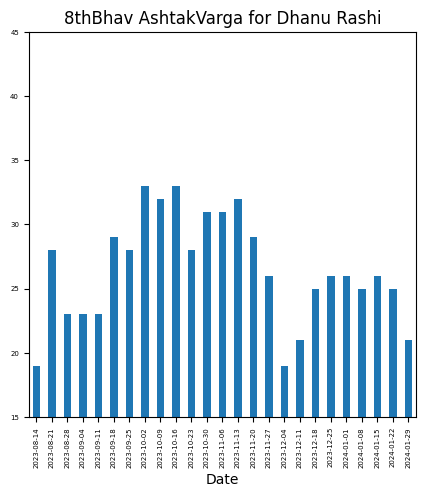

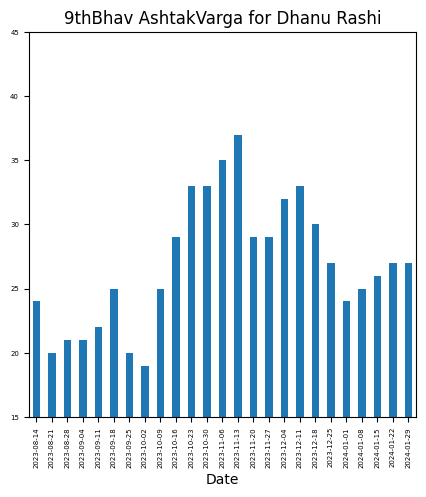

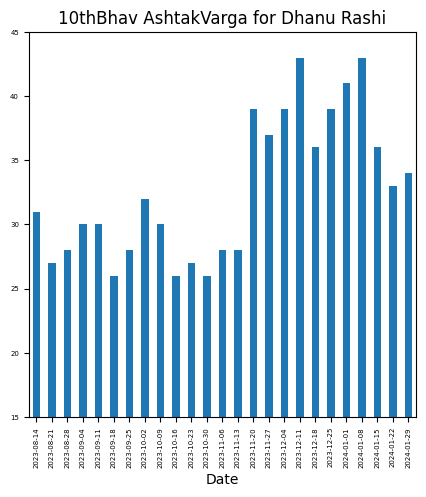

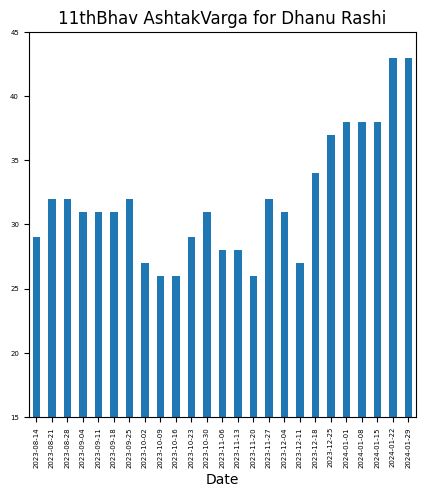

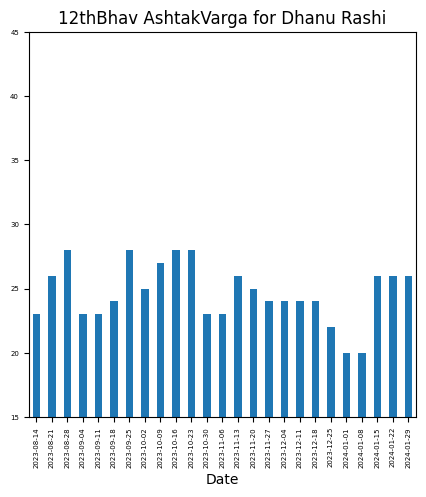

In [22]:
#df8V_Rashi, df8V_Bhav =Transitz(24,7)
!rm *.png
RollForward(24,7)

In [23]:
#BhavCols = p21.BhavList[1:]
#BhavCols

In [24]:
for i in p21.BhavList[1:]:
    L = [i]
    txt = L[0] + 'Bhav AshtakVarga Points'
    t = df8V_Bhav.plot(y=L,kind='bar', ylim=(15, 50), figsize = (8,4), title = txt, legend=False).get_figure();
    iName = 'Bhav'+L[0]+'.png'
    t.savefig(iName)

NameError: ignored

In [ ]:
print("\033[1m"+'जय पराशर'+"\033[0m")
print(datetime.now(pytz.timezone('Asia/Calcutta')))

#Chronobooks <br>
![alt text](https://1.bp.blogspot.com/-lTiYBkU2qbU/X1er__fvnkI/AAAAAAAAjtE/GhDR3OEGJr4NG43fZPodrQD5kbxtnKebgCLcBGAsYHQ/s600/Footer2020-600x200.png)<hr>
Chronotantra and Chronoyantra are two science fiction novels that explore the collapse of human civilisation on Earth and then its rebirth and reincarnation both on Earth as well as on the distant worlds of Mars, Titan and Enceladus. But is it the human civilisation that is being reborn? Or is it some other sentience that is revealing itself.
If you have an interest in AI and found this material useful, you may consider buying these novels, in paperback or kindle, from [http://bit.ly/chronobooks](http://bit.ly/chronobooks)

# Leftovers

In [ ]:
#
#Get List of Persons whose charts are found in the database
#
selCond = {}                                              # All Charts
#pd.DataFrame(list(p21.kollection.find(selCond,p21.selCols)))
#pd.DataFrame(list(p21.kollection.find(selCond,{'pid.name':1,'_id':0})))
pd.DataFrame(list(p21.kollection.find(selCond,{'pid.name':1})))
#pd.DataFrame(list(p21.kollection.find(selCond,p21.selCols)))


In [ ]:
#
# Download last Report File
#
#files.download(ReportFile)

In [ ]:
#!rm *.doc